# Cell size and genomic context

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.legend import Legend
import seaborn as sns
import re

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [3]:
from scipy.stats import spearmanr
import statsmodels.api as sm
import requests
import time

In [4]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 15,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

Load data

In [5]:
df = pd.read_table('../phylogeny/place/fine_all.tsv', index_col = 0)
df['log_svratio'] = np.log10(df['volume'] / df['surface'])
df.shape

(5380, 23)

### Get species with available genomic information

In [6]:
df1 = df[df['node'].str.contains('G')].copy()

**Because of our methodology (phylogenetic placement) some species have been assigned to the same genome, so we need to get rid of the duplicates and select only those species whose taxonomic name matches the genome name**

In [7]:
dft = pd.read_table('../phylogeny/tax2tree/filled_ranks.tsv', index_col = 0)

In [8]:
df1['is_species'] = df1['node'].apply(lambda x: dft.loc[x]['species'] if x in dft.index else np.nan)

In [9]:
df1 = df1[df1['species'] == df1['is_species']]

Sort genomes by size

In [10]:
df1.sort_values(by = ['log_svratio'], inplace = True)

In [11]:
genomes = df1['node'].to_list()

In [12]:
len(genomes)

1363

### Load KEGG genome annotations

In [13]:
def loadKEGGv2(fIn):
    annot = {}
    
    with open(fIn, 'r') as f:
        for line in f:
            genome = line.strip().split('\t')[0].split('_')[0]
            kos = line.strip().split('\t')[1:]
            
            if genome not in annot.keys():
                annot[genome] = [ko for ko in kos]
            else:
                for ko in kos:
                    annot[genome].append(ko)
                
    return annot

In [14]:
def loadDescription(fIn):
    '''
    Function that loads the description of an annotation system e.g. Uniref, KEGG, GO
    Inputs:
        fIn: file containing the descriptions
    Outputs:
        description: dictionary with functional units (str) as keys and their description (str) as values
    '''
    
    # Structure
    description = {}
    
    # Iterate over file
    with open(fIn, 'r') as f:
        for line in f:
            funit = line.strip().split('\t')[0]
            desc = line.strip().split('\t')[1]
            description[funit] = desc
            
    return description

In [15]:
def loadMapping(fIn):
    '''
    Function that loas a mapping file between two annotation systems
    Inputs:
        fIn: file containing the mapping
    Outputs:
        mapping: dictionary with uniref (str) as keys and ko (str) as values
    '''
    
    # Structure
    mapping = {}
    
    # Iterate over file
    with open(fIn, 'r') as f:
        for line in f:
            uni = line.strip().split('\t')[0]
            ko = line.strip().split('\t')[1]
            mapping[uni] = ko
    
    return mapping

In [16]:
def loadMapping3(fIn):
    '''
    Function that loas a mapping file between two annotation systems
    Inputs:
        fIn: file containing the mapping
    Outputs:
        mapping: dictionary with uniref (str) as keys and kos (str) as list
    '''
    
    # Structure
    mapping = {}
    
    # Iterate over file
    with open(fIn, 'r') as f:
        for line in f:
            ko = line.strip().split('\t')[0]
            rclass = line.strip().split('\t')[2]
            mapping[ko] = rclass
    
    return mapping

In [17]:
def loadMapping2(fIn):
    '''
    Function that loas a mapping file between two annotation systems
    Inputs:
        fIn: file containing the mapping
    Outputs:
        mapping: dictionary with uniref (str) as keys and kos (str) as list
    '''
    
    # Structure
    mapping = {}
    
    # Iterate over file
    with open(fIn, 'r') as f:
        for line in f:
            uni = line.strip().split('\t')[0]
            ko = line.strip().split('\t')[1:]
            mapping[uni] = ko
    
    return mapping

In [18]:
%%time
orf_to_kegg = loadKEGGv2('function/kegg/orf-to-ko.map')

CPU times: user 27.2 s, sys: 1.33 s, total: 28.5 s
Wall time: 28.5 s


In [19]:
%%time
description_pathways = loadDescription('function/kegg/pathways_curated.txt')

CPU times: user 1.62 ms, sys: 0 ns, total: 1.62 ms
Wall time: 936 µs


In [20]:
%%time
map_ko_pathways2 = loadMapping2('function/kegg/ko-to-pathway.map')

CPU times: user 9.11 ms, sys: 15 µs, total: 9.12 ms
Wall time: 8.22 ms


Get genomes annotated

In [21]:
genomes2 = list(set(genomes).intersection(set(list(orf_to_kegg.keys()))))

In [22]:
df2 = df1[df1['node'].isin(genomes2)].copy()
df2.sort_values(['log_svratio'], inplace = True)
genomes2 = df2['node'].to_list()

In [23]:
len(genomes2)

1361

Assesing the existence of autotrophs by looking at rubisco genes (largest and smallest subunit)

In [24]:
def polyReg(degree = 2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))
param_grid = {'polynomialfeatures__degree': np.arange(10)}

In [25]:
seed = 42

In [26]:
mu = np.mean(df2['log_svratio'])
std = np.std(df2['log_svratio'])

In [27]:
rubisco = ['K01601', 'K01602']

In [28]:
hits = []
for genome in genomes2:
    counts = set()
    for ko in orf_to_kegg[genome]:
        annotated_orfs = len(orf_to_kegg[genome])
        if ko in rubisco:
            counts.add(ko)
    # If both subunits exist in the genome (regardless of the number of copies), then genome has rubisco 
    if len(counts) == 2:
        hits.append(1)
    else:
        hits.append(0)

Number of genomes with rubisco (1) and without (0)

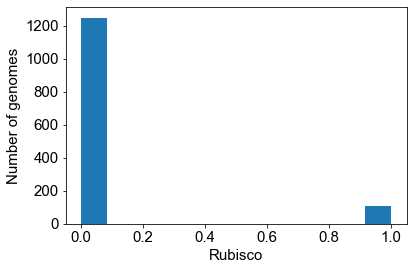

In [29]:
plt.figure()
plt.hist(hits, bins = 'auto')
plt.ylabel('Number of genomes')
plt.xlabel('Rubisco')
plt.show()

Bin cell sizes

In [30]:
df2['log_svratio'].describe()

count    1361.000000
mean       -0.876213
std         0.236731
min        -1.612419
25%        -1.010658
50%        -0.886057
75%        -0.754558
max         0.698970
Name: log_svratio, dtype: float64

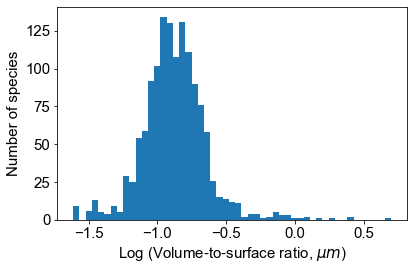

In [31]:
plt.figure()
plt.hist(df2['log_svratio'], bins = 'auto')
plt.ylabel('Number of species')
plt.xlabel('Log (Volume-to-surface ratio, $\\mu m$)')
plt.show()

In [32]:
df2['log_svratio'].min()

-1.6124189775783255

In [33]:
df2['log_svratio'].max()

0.6989700043360185

In [34]:
bins = np.arange(-1.65, 0.8, 0.2)
bins.shape

(13,)

In [35]:
bins

array([-1.65, -1.45, -1.25, -1.05, -0.85, -0.65, -0.45, -0.25, -0.05,
        0.15,  0.35,  0.55,  0.75])

Find species within a given bin

In [36]:
pd_binidx = np.digitize(df2['log_svratio'], bins)

In [37]:
pd_binidx.min(), pd_binidx.max()

(1, 12)

Sample k species within each bin

In [38]:
k = 2000

**The last bin is always articifial. If you consider them in ranges, e.g. [0, 1], [1, 2] there are 2 bins but three values for the array bins = [0, 1, 2]**

In [39]:
binned = []
np.random.seed(42)
for i in range(len(bins)):
    # Get idx of points
    idx = np.where(pd_binidx == i + 1)[0]
    # Randomly sample k data points 
    binned.append(np.random.choice(idx, k, replace = False) if len(idx) > k else idx)
    print(f'bin {i + 1}, n = {len(idx)}, n_sampled = {len(binned[i])}')

bin 1, n = 27, n_sampled = 27
bin 2, n = 22, n_sampled = 22
bin 3, n = 197, n_sampled = 197
bin 4, n = 511, n_sampled = 511
bin 5, n = 452, n_sampled = 452
bin 6, n = 107, n_sampled = 107
bin 7, n = 22, n_sampled = 22
bin 8, n = 11, n_sampled = 11
bin 9, n = 7, n_sampled = 7
bin 10, n = 2, n_sampled = 2
bin 11, n = 2, n_sampled = 2
bin 12, n = 1, n_sampled = 1
bin 13, n = 0, n_sampled = 0


In [40]:
sampled_idx = np.concatenate(binned)

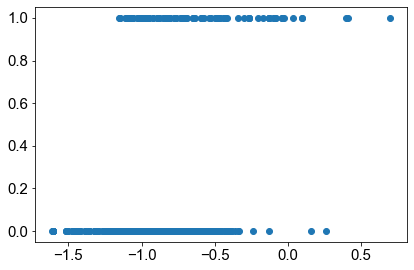

In [41]:
plt.figure()
xpos = df2['log_svratio'].to_numpy()[sampled_idx]
y = np.array(hits)[sampled_idx]
plt.scatter(xpos, y)
plt.show()

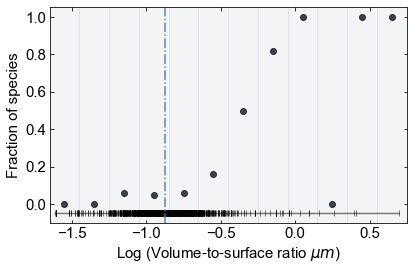

In [42]:
plt.figure()

# Data
data = [np.array(hits)[binned[i]] for i in range(len(bins))]
x, y = (bins[:-1] + bins[1:]) / 2, np.array([np.count_nonzero(b == 1) / len(b) if len(b) != 0 else 0 for b in data])

# Plot
plt.scatter(x, y[:-1], alpha = 0.8, color = '#000814')
plt.plot(df2['log_svratio'], np.full_like(df2['log_svratio'], -0.05), color = 'black', marker = '|',
                     alpha = 0.5)
plt.ylabel('Fraction of species')
plt.xlabel(f'Log (Volume-to-surface ratio $\\mu m$)')

for b in range(len(bins) - 1):
    lower = bins[b]
    upper = bins[b + 1]
    plt.axvspan(lower, upper, alpha = 0.1, color = '#8d99ae', lw = 1.0)
plt.axvline(x = np.mean(df2['log_svratio']), color = '#457b9d', linestyle = 'dashdot', alpha = 0.9)
    
plt.xlim(x.min() - 0.1, x.max() + 0.1)    
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')

# plt.savefig('figures_all/kegg_rubisco.svg')
plt.show()

### Combine bins with less than *k* elements

In [43]:
def combine_bins(bins, k, size):
    # Lists to store the resulting bins, combined bins, and new bins
    binned = []
    combined_bins = []
    new_bins = []
    
    # Variables to keep track of the start of a combined bin and its elements
    combined_start = None
    combined_elems = []
    
    # Iterate over the bins
    for i in range(len(bins) - 1):
        # Get elements within the current bin
        elems = size[(size >= bins[i]) & (size < bins[i + 1])]
        
        # If the number of elements in the bin is less than 'k'
        if len(elems) < k:
            # Add elements to the combined elements list
            combined_elems.extend(elems)
            # Set the combined start if it's not already set
            combined_start = combined_start if combined_start is not None else bins[i]
        else:
            # If there are combined elements from previous bins, add them to 'binned' and create a combined bin
            if combined_elems:
                binned.append(combined_elems)
                combined_bins.append([combined_start, bins[i]])
                new_bins.append([combined_start, bins[i]])
                combined_start = None
                combined_elems = []

            # Add the elements of the current bin to 'binned' and create a new bin
            binned.append(elems)
            new_bins.append([bins[i], bins[i + 1]])

    # Check if there are remaining combined elements and add them to the last bin
    if combined_elems:
        binned.append(combined_elems)
        combined_bins.append([combined_start, bins[-1]])
        new_bins.append([combined_start, bins[-1]])

    return binned, combined_bins, new_bins

In [44]:
binned, combined_bins, new_bins = combine_bins(bins, 10, df2['log_svratio'].to_numpy())

In [45]:
binned_idx = []
count = -1
for b in binned:
    tmp = []
    for elem in b:
        count += 1
        tmp.append(count)
    binned_idx.append(tmp)

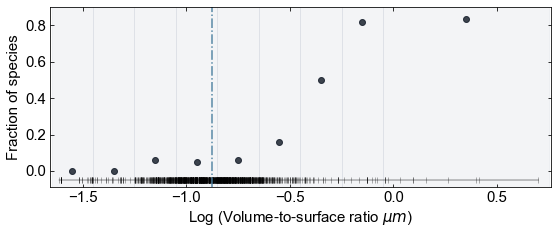

In [46]:
plt.figure(figsize = (8, 3.5))

# Plot fraction of species within a bin
for i, idx in enumerate(binned_idx):
    x = (new_bins[i][1] + new_bins[i][0]) / 2
    y = np.count_nonzero(np.array(hits)[idx] == 1) / len(idx)
    plt.scatter(x, y, alpha = 0.8, color = '#000814')
    plt.axvspan(new_bins[i][0], new_bins[i][1], alpha = 0.1, color = '#8d99ae', lw = 1.0)
    
# Plot species as straight lines
plt.plot(df2['log_svratio'], np.full_like(df2['log_svratio'], -0.05), color = 'black', marker = '|',
                     alpha = 0.3)

# Mean
plt.axvline(x = np.mean(df2['log_svratio']), color = '#457b9d', linestyle = 'dashdot', alpha = 0.9)

plt.ylabel('Fraction of species')
plt.xlabel(f'Log (Volume-to-surface ratio $\\mu m$)')

plt.xlim(new_bins[0][0] - 0.01, new_bins[-1][1] + 0.01)    
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.ylim(-0.09, 0.9)

plt.savefig('../figures_all/kegg_rubisco.svg')

plt.show()

All 63 genes in [KEGG photosynthesis](https://www.genome.jp/kegg-bin/show_pathway?category=Bacteria&mapno=00195) pathway

In [47]:
photo = ['K02108','K02109','K02110','K02111','K02112','K02113','K02114','K02115','K02634','K02635',
         'K02636','K02637','K02638','K02639','K02640','K02641','K02642','K02643','K02689','K02690',
         'K02691','K02692','K02693','K02694','K02695','K02696','K02697','K02698','K02699','K02700',
         'K02701','K02702','K02703','K02704','K02705','K02706','K02707','K02708','K02709','K02710',
         'K02711','K02712','K02713','K02714','K02716','K02717','K02718','K02719','K02720','K02721',
         'K02722','K02723','K02724','K03541','K03542','K03689','K08901','K08902','K08903','K08904',
         'K08905','K08906','K14332']

All 117 genes in [KEGG carbon fixation in prokaryotes](https://www.genome.jp/kegg-bin/show_pathway?category=Bacteria&mapno=00720) pathway

In [48]:
carbon = ['K00024','K00031','K00169','K00170','K00171','K00172','K00174','K00175','K00176',
          'K00177','K00189','K00194','K00196','K00197','K00198','K00233','K00239','K00240',
          'K00241','K00242','K00244','K00245','K00246','K00247','K00297','K00625','K00626',
          'K00925','K01006','K01007','K01491','K01500','K01595','K01648','K01675','K01676',
          'K01677','K01678','K01679','K01681','K01682','K01774','K01847','K01848','K01849',
          'K01895','K01902','K01903','K01938','K01958','K01959','K01960','K01961','K01962',
          'K01963','K01964','K02160','K03737','K05299','K05606','K08691','K09709','K13788',
          'K14138','K14449','K14465','K14466','K14467','K14468','K14469','K14470','K14471',
          'K14472','K14534','K15016','K15017','K15018','K15019','K15020','K15022','K15023',
          'K15024','K15036','K15037','K15038','K15039','K15052','K15230','K15231','K15232',
          'K15233','K15234','K18209','K18210','K18556','K18557','K18558','K18559','K18560',
          'K18593','K18594','K18602','K18603','K18604','K18605','K18859','K18860','K18861',
          'K22015','K25007','K25008','K25123','K25124','K25774','K25995','K25996','K26318']

All 36 genes in [KEGG carbon fixation in photosynthetic organisms](https://www.genome.jp/kegg-bin/show_pathway?category=Bacteria&mapno=00720) pathway

In [49]:
carbon1 = ['K00024','K00025','K00026','K00028','K00029','K00051','K00134','K00150','K00615',
           'K00814','K00855','K00927','K01006','K01086','K01100','K01595','K01601','K01602',
           'K01610','K01621','K01623','K01624','K01783','K01803','K01807','K01808','K02446',
           'K03841','K04041','K05298','K11214','K11532','K11645','K14272','K14454','K14455']

All 223 genes in [KEGG oxidative phosphorylation](https://www.genome.jp/kegg-bin/show_pathway?category=Bacteria&mapno=00190) pathway

In [50]:
oxphos = ['K00233','K00234','K00235','K00236','K00237','K00239','K00240','K00241','K00242',
          'K00244','K00245','K00246','K00247','K00330','K00331','K00332','K00333','K00334',
          'K00335','K00336','K00337','K00338','K00339','K00340','K00341','K00342','K00343',
          'K00404','K00405','K00406','K00407','K00410','K00411','K00412','K00413','K00414',
          'K00415','K00416','K00417','K00418','K00419','K00420','K00424','K00425','K00426',
          'K00937','K01507','K01535','K01542','K01543','K01544','K01549','K02107','K02108',
          'K02109','K02110','K02111','K02112','K02113','K02114','K02115','K02117','K02118',
          'K02119','K02120','K02121','K02122','K02123','K02124','K02125','K02126','K02127',
          'K02128','K02129','K02130','K02131','K02132','K02133','K02134','K02135','K02136',
          'K02137','K02138','K02139','K02140','K02141','K02142','K02143','K02144','K02145',
          'K02146','K02147','K02148','K02149','K02150','K02151','K02152','K02153','K02154',
          'K02155','K02256','K02257','K02258','K02259','K02260','K02261','K02262','K02263',
          'K02264','K02265','K02266','K02267','K02268','K02269','K02270','K02271','K02272',
          'K02273','K02274','K02275','K02276','K02277','K02297','K02298','K02299','K02300',
          'K02826','K02827','K02828','K02829','K03661','K03662','K03878','K03879','K03880',
          'K03881','K03882','K03883','K03884','K03885','K03886','K03887','K03888','K03889',
          'K03890','K03891','K03934','K03935','K03936','K03937','K03938','K03939','K03940',
          'K03941','K03942','K03943','K03944','K03945','K03946','K03947','K03948','K03949',
          'K03950','K03951','K03952','K03953','K03954','K03955','K03956','K03957','K03958',
          'K03959','K03960','K03961','K03962','K03963','K03964','K03965','K03966','K03967',
          'K03968','K05572','K05573','K05574','K05575','K05576','K05577','K05578','K05579',
          'K05580','K05581','K05582','K05583','K05584','K05585','K05586','K05587','K05588',
          'K06019','K08738','K11351','K11352','K11353','K11725','K11726','K13378','K13380',
          'K15408','K15862','K15863','K15986','K18859','K18860','K22468','K22501','K24007',
          'K24008','K24009','K24010','K24011','K25801','K25995','K25996']

In [51]:
def find_hits(set_genes, percent):
    'Function that finds the set of genes in a set of genomes'
    hits = []
    for genome in genomes2:
        counts = set()
        for ko in orf_to_kegg[genome]:
            annotated_orfs = len(orf_to_kegg[genome])
            if ko in set_genes:
                counts.add(ko)
    #     hits.append(counts)

        # If at least x% out of the four major genes are present, then count as existing 
        if len(counts) >= int(len(set_genes) * percent):
            hits.append(1)
        else:
            hits.append(0)
    return hits

In [52]:
hits = []
set_genes = photo
percent = 0.7
for genome in genomes2:
    counts = set()
    for ko in orf_to_kegg[genome]:
        annotated_orfs = len(orf_to_kegg[genome])
        if ko in set_genes:
            counts.add(ko)
#     hits.append(counts)
            
    # If at least x% out of the four major genes are present, then count as existing 
    if len(counts) >= int(len(set_genes) * percent):
        hits.append(1)
    else:
        hits.append(0)

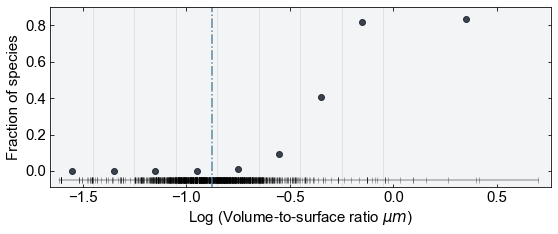

In [53]:
plt.figure(figsize = (8, 3.5))

# Plot fraction of species within a bin
for i, idx in enumerate(binned_idx):
    x = (new_bins[i][1] + new_bins[i][0]) / 2
    y = np.count_nonzero(np.array(hits)[idx] == 1) / len(idx)
    plt.scatter(x, y, alpha = 0.8, color = '#000814')
    plt.axvspan(new_bins[i][0], new_bins[i][1], alpha = 0.1, color = '#8d99ae', lw = 1.0)
    
# Plot species as straight lines
plt.plot(df2['log_svratio'], np.full_like(df2['log_svratio'], -0.05), color = 'black', marker = '|',
                     alpha = 0.3)

# Mean
plt.axvline(x = np.mean(df2['log_svratio']), color = '#457b9d', linestyle = 'dashdot', alpha = 0.9)

plt.ylabel('Fraction of species')
plt.xlabel(f'Log (Volume-to-surface ratio $\\mu m$)')

plt.xlim(new_bins[0][0] - 0.01, new_bins[-1][1] + 0.01)    
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.ylim(-0.09, 0.9)

plt.savefig('../figures_all/kegg_photo.svg')
plt.show()

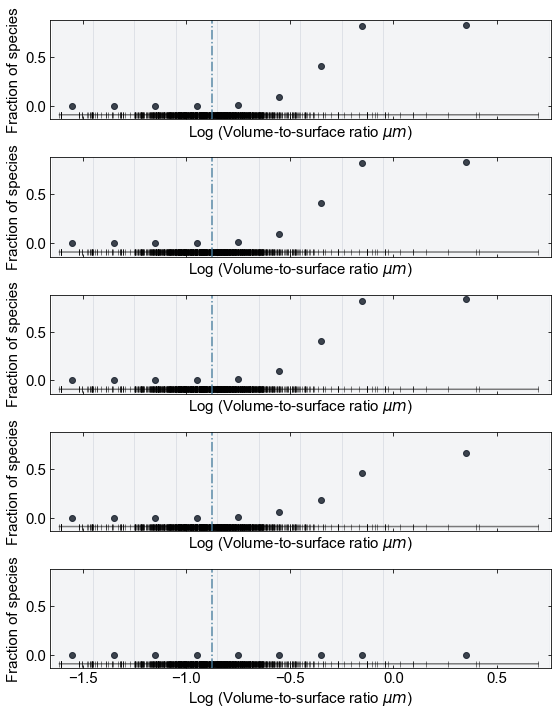

In [54]:
percents = [0.5, 0.6, 0.7, 0.8, 0.9]

fig, ax = plt.subplots(len(percents), 1, figsize = (8, 10), 
                       sharey = True, sharex = True)

for i, percent in enumerate(percents):
    hits = find_hits(photo, percent)
    # Plot fraction of species within a bin
    for j, idx in enumerate(binned_idx):
        x = (new_bins[j][1] + new_bins[j][0]) / 2
        y = np.count_nonzero(np.array(hits)[idx] == 1) / len(idx)
        ax[i].scatter(x, y, alpha = 0.8, color = '#000814')
        ax[i].axvspan(new_bins[j][0], new_bins[j][1], alpha = 0.1, color = '#8d99ae', lw = 1.0)

    # Plot species as straight lines
    ax[i].plot(df2['log_svratio'], np.full_like(df2['log_svratio'], -0.09), color = 'black', marker = '|',
                         alpha = 0.5)

    # Mean
    ax[i].axvline(x = np.mean(df2['log_svratio']), color = '#457b9d', linestyle = 'dashdot', alpha = 0.9)

    ax[i].set_ylabel('Fraction of species')
    ax[i].set_xlabel(f'Log (Volume-to-surface ratio $\\mu m$)')

    ax[i].set_xlim(new_bins[0][0] - 0.01, new_bins[-1][1] + 0.01)    
    ax[i].tick_params(top = True, right = True, direction = 'in', which = 'both')
# plt.savefig('figures_all/kegg_photo.svg')
plt.show()

## Chemotaxis

Genes: 
* cheA, cheB, 
* motA, motB

In [55]:
chemo = ['K03407', 'K03412', 'K02556', 'K02557']

Genes:
* cheA, cheB, cheC, cheD, cheV, cheW, cheX, cheY, cheZ
* motA, motB

In [56]:
chemo1 = ['K03407', 'K03412', 'K03410', 'K03411', 'K03415', 'K03408', 'K03409', 'K03413', 'K03414',
         'K02556', 'K02557']

Genes: 
* cheA, cheB, cheC, cheD, cheV, cheW, cheX, cheY, cheZ, 
* FliG, FliM, fliN (Type III secretion system, MS/C ring)
* motA, motB (Flagellar stator)

In [57]:
chemo2 = ['K03407', 'K03412', 'K03410', 'K03411', 'K03415', 'K03408', 'K03409', 'K03413', 'K03414',
          'K02410', 'K02416', 'K02417',
         'K02556', 'K02557']

All 26 genes from [KEGG chemotaxis](https://www.genome.jp/kegg-bin/show_pathway?category=Bacteria&mapno=02030) pathway

In [58]:
chemo3 = ['K00575','K02410','K02416','K02417','K02556','K02557','K03406','K03407',
          'K03408','K03409','K03410','K03411','K03412','K03413','K03414','K03415',
          'K03776','K05874','K05875','K05876','K05877','K10108','K10439','K10540','K12368','K13924']

In [59]:
hits = []
set_genes = chemo3
percent = 0.7
for genome in genomes2:
    counts = set()
    for ko in orf_to_kegg[genome]:
        annotated_orfs = len(orf_to_kegg[genome])
        if ko in set_genes:
            counts.add(ko)
#     hits.append(counts)
            
    # If at least x% out of the four major genes are present, then count as existing 
    if len(counts) >= int(len(set_genes) * percent):
        hits.append(1)
    else:
        hits.append(0)

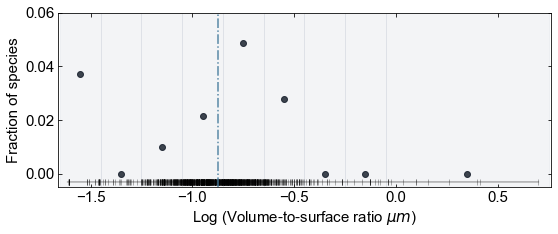

In [60]:
plt.figure(figsize = (8, 3.5))

# Plot fraction of species within a bin
for i, idx in enumerate(binned_idx):
    x = (new_bins[i][1] + new_bins[i][0]) / 2
    y = np.count_nonzero(np.array(hits)[idx] == 1) / len(idx)
    plt.scatter(x, y, alpha = 0.8, color = '#000814')
    plt.axvspan(new_bins[i][0], new_bins[i][1], alpha = 0.1, color = '#8d99ae', lw = 1.0)
    
# Plot species as straight lines
plt.plot(df2['log_svratio'], np.full_like(df2['log_svratio'], -0.003), color = 'black', marker = '|',
                     alpha = 0.3)

# Mean
plt.axvline(x = np.mean(df2['log_svratio']), color = '#457b9d', linestyle = 'dashdot', alpha = 0.9)

plt.ylabel('Fraction of species')
plt.xlabel(f'Log (Volume-to-surface ratio $\\mu m$)')

plt.xlim(new_bins[0][0] - 0.01, new_bins[-1][1] + 0.01)    
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.ylim(-0.005, 0.06)
plt.savefig('../figures_all/kegg_chemotaxis.svg')

plt.show()

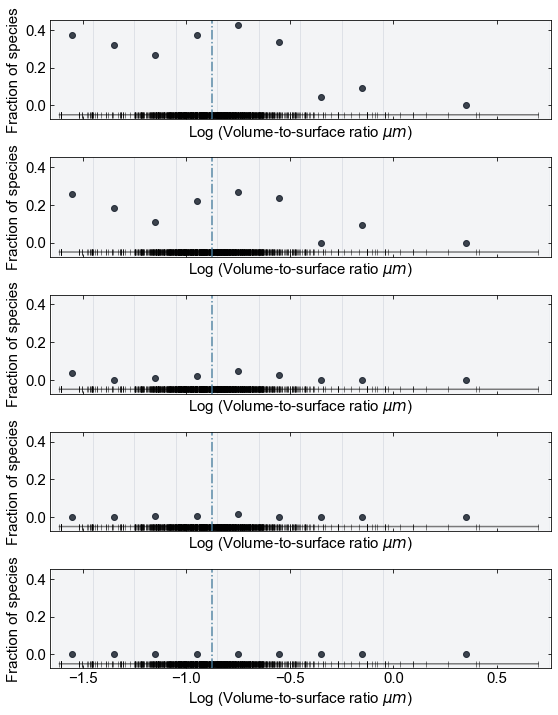

In [61]:
percents = [0.5, 0.6, 0.7, 0.8, 0.9]

fig, ax = plt.subplots(len(percents), 1, figsize = (8, 10), 
                       sharey = True, sharex = True)

for i, percent in enumerate(percents):
    hits = find_hits(chemo3, percent)
    # Plot fraction of species within a bin
    for j, idx in enumerate(binned_idx):
        x = (new_bins[j][1] + new_bins[j][0]) / 2
        y = np.count_nonzero(np.array(hits)[idx] == 1) / len(idx)
        ax[i].scatter(x, y, alpha = 0.8, color = '#000814')
        ax[i].axvspan(new_bins[j][0], new_bins[j][1], alpha = 0.1, color = '#8d99ae', lw = 1.0)

    # Plot species as straight lines
    ax[i].plot(df2['log_svratio'], np.full_like(df2['log_svratio'], -0.05), color = 'black', marker = '|',
                         alpha = 0.5)

    # Mean
    ax[i].axvline(x = np.mean(df2['log_svratio']), color = '#457b9d', linestyle = 'dashdot', alpha = 0.9)

    ax[i].set_ylabel('Fraction of species')
    ax[i].set_xlabel(f'Log (Volume-to-surface ratio $\\mu m$)')

    ax[i].set_xlim(new_bins[0][0] - 0.01, new_bins[-1][1] + 0.01)    
    ax[i].tick_params(top = True, right = True, direction = 'in', which = 'both')
# plt.savefig('figures_all/kegg_photo.svg')
plt.show()

## Flagellar

Flagellar genes:
* motA, motB (stator)
* flgL, flgK (hook filament junction)
* fliC (flagellin)

In [62]:
flag = ['K02556', 'K02557', 
        'K02397', 'K02396', 
        'K02406']

Flagellar genes:
* motA, motB (stator)
* flgL, flgK (hook filament junction)
* fliC (flagellin)
* FliG, FliM, fliN (Type III secretion system, MS/C ring)
* fliD, fliS, fliT (filament cap, chaperon)
* flgM, flgN, fliY, fliZ (Regulator) 

In [63]:
flag1 = ['K02556', 'K02557', 
        'K02397', 'K02396', 
        'K02406',
       'K02410', 'K02416', 'K02417',
        'K02407', 'K02422', 'K02423',
        'K02398', 'K02399', 'K02424', 'K02424']

All 55 genes from [KEGG flagellar assembly](https://www.genome.jp/kegg-bin/show_pathway?category=Bacteria&mapno=02040) pathway

In [64]:
flag2 = ['K02386','K02387','K02388','K02389','K02390','K02391','K02392','K02393','K02394',
         'K02395','K02396','K02397','K02398','K02399','K02400','K02401','K02402','K02403',
         'K02405','K02406','K02407','K02408','K02409','K02410','K02411','K02412','K02413',
         'K02414','K02415','K02416','K02417','K02418','K02419','K02420','K02421','K02422',
         'K02423','K02424','K02425','K02556','K02557','K03086','K03092','K03516','K09860',
         'K10564','K10565','K10941','K10943','K13820','K21217','K21218','K24343','K24344','K24346']

In [65]:
hits = []
set_genes = flag2
percent = 0.7
for genome in genomes2:
    counts = set()
    for ko in orf_to_kegg[genome]:
        annotated_orfs = len(orf_to_kegg[genome])
        if ko in set_genes:
            counts.add(ko)
#     hits.append(counts)
            
    # If both subunits exist in the genome (regardless of the number of copies), then genome has rubisco 
    if len(counts) >= int(len(set_genes) * percent):
        hits.append(1)
    else:
        hits.append(0)

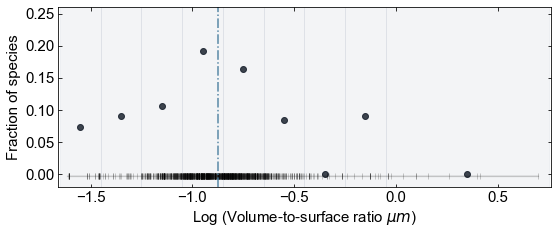

In [66]:
plt.figure(figsize = (8, 3.5))

# Plot fraction of species within a bin
for i, idx in enumerate(binned_idx):
    x = (new_bins[i][1] + new_bins[i][0]) / 2
    y = np.count_nonzero(np.array(hits)[idx] == 1) / len(idx)
    plt.scatter(x, y, alpha = 0.8, color = '#000814')
    plt.axvspan(new_bins[i][0], new_bins[i][1], alpha = 0.1, color = '#8d99ae', lw = 1.0)
    
# Plot species as straight lines
plt.plot(df2['log_svratio'], np.full_like(df2['log_svratio'], -0.003), color = 'black', marker = '|',
                     alpha = 0.2)

# Mean
plt.axvline(x = np.mean(df2['log_svratio']), color = '#457b9d', linestyle = 'dashdot', alpha = 0.9)

plt.ylabel('Fraction of species')
plt.xlabel(f'Log (Volume-to-surface ratio $\\mu m$)')

plt.xlim(new_bins[0][0] - 0.01, new_bins[-1][1] + 0.01)    
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.ylim(-0.02, 0.26)

plt.savefig('../figures_all/kegg_flagellar.svg')
plt.show()

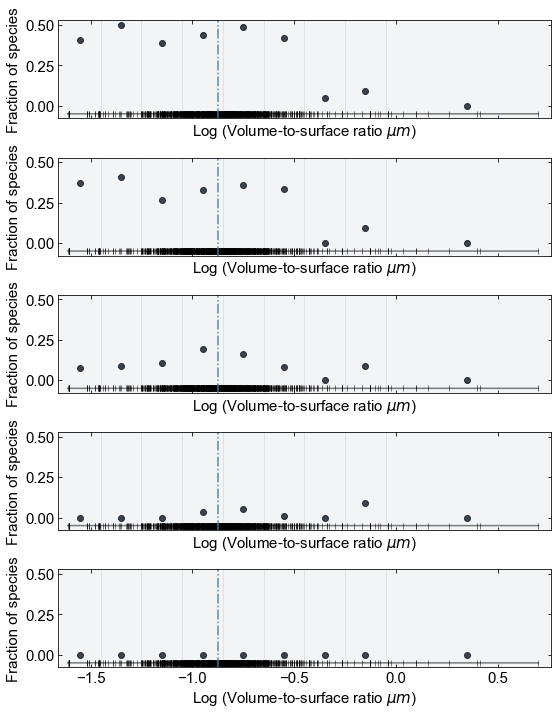

In [67]:
percents = [0.5, 0.6, 0.7, 0.8, 0.9]

fig, ax = plt.subplots(len(percents), 1, figsize = (8, 10), 
                       sharey = True, sharex = True)

for i, percent in enumerate(percents):
    hits = find_hits(flag2, percent)
    # Plot fraction of species within a bin
    for j, idx in enumerate(binned_idx):
        x = (new_bins[j][1] + new_bins[j][0]) / 2
        y = np.count_nonzero(np.array(hits)[idx] == 1) / len(idx)
        ax[i].scatter(x, y, alpha = 0.8, color = '#000814')
        ax[i].axvspan(new_bins[j][0], new_bins[j][1], alpha = 0.1, color = '#8d99ae', lw = 1.0)

    # Plot species as straight lines
    ax[i].plot(df2['log_svratio'], np.full_like(df2['log_svratio'], -0.05), color = 'black', marker = '|',
                         alpha = 0.5)

    # Mean
    ax[i].axvline(x = np.mean(df2['log_svratio']), color = '#457b9d', linestyle = 'dashdot', alpha = 0.9)

    ax[i].set_ylabel('Fraction of species')
    ax[i].set_xlabel(f'Log (Volume-to-surface ratio $\\mu m$)')

    ax[i].set_xlim(new_bins[0][0] - 0.01, new_bins[-1][1] + 0.01)    
    ax[i].tick_params(top = True, right = True, direction = 'in', which = 'both')
# plt.savefig('figures_all/kegg_photo.svg')
plt.show()

## Other pathways

In [68]:
# def get_orthologs_for_pathway(pathway_id):
    
#     # URL for request
#     url = f"http://rest.kegg.jp/link/ko/{pathway_id}"
#     response = requests.get(url)
#     orthologs = []
    
#     if response.status_code == 200:
#         lines = response.text.strip().split("\n")
#         # Some pathways are not defined in bacteria
#         if len(lines) > 1:
#             ort = [line.split("\t")[1].split(':')[1] for line in lines] 
#             orthologs = ort
#     else:
#         print("Error:", response.status_code)
    
#     return orthologs

In [69]:
# %%time
# genes_pathways = {}

# # for pathway, desc in list(description_pathways.items())[146:]:
# for pathway, desc in description_pathways.items():
#     pathway_id = f'path:map{pathway[2:]}'
#     orthologs = get_orthologs_for_pathway(pathway_id)
#     genes_pathways[pathway] = orthologs
#     # Wait a bit 
#     time.sleep(60)

In [70]:
# with open('function/kegg/pathways_genes.txt', 'w') as f: 
#     for pathway, genes in genes_pathways.items():
#         for gene in genes:
#             f.write(f'{pathway},{gene}\n')

In [71]:
# genes_pathways1 = {}
# with open('function/kegg/pathways_genes.txt', 'r') as f:
#     for line in f:
#         ptw, gene = line.strip().split(',')[0], line.strip().split(',')[1]
#         if ptw not in genes_pathways1.keys():
#             genes_pathways1[ptw] = [gene]
#         else:
#             genes_pathways1[ptw].append(gene)

In [72]:
# len(genes_pathways1)

In [73]:
# %%time
# percent = 0.7
# for pathway, genes in genes_pathways1.items():
#     plt.figure()
#     print(pathway)
#     hits = find_hits(genes, percent)
#     # Plot fraction of species within a bin
#     for i, idx in enumerate(binned_idx):
#         x = (new_bins[i][1] + new_bins[i][0]) / 2
#         y = np.count_nonzero(np.array(hits)[idx] == 1) / len(idx)
#         plt.scatter(x, y, alpha = 0.8, color = '#000814')
#         plt.axvspan(new_bins[i][0], new_bins[i][1], alpha = 0.1, color = '#8d99ae', lw = 1.0)

#     # Plot species as straight lines
#     plt.plot(df2['log_svratio'], np.full_like(df2['log_svratio'], -0.02), color = 'black', marker = '|',
#                          alpha = 0.5)

#     # Mean
#     plt.axvline(x = np.mean(df2['log_svratio']), color = '#457b9d', linestyle = 'dashdot', alpha = 0.9)

#     plt.ylabel('Fraction of species')
#     plt.xlabel(f'Log (Volume-to-surface ratio $\\mu m$)')

#     plt.xlim(new_bins[0][0] - 0.01, new_bins[-1][1] + 0.01)    
#     plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
    
# plt.show()

In [74]:
# %%time
# percent = 0.4
# for pathway, genes in genes_pathways1.items():
#     plt.figure()
#     print(pathway)
#     hits = find_hits(genes, percent)
#     # Plot fraction of species within a bin
#     for i, idx in enumerate(binned_idx):
#         x = (new_bins[i][1] + new_bins[i][0]) / 2
#         y = np.count_nonzero(np.array(hits)[idx] == 1) / len(idx)
#         plt.scatter(x, y, alpha = 0.8, color = '#000814')
#         plt.axvspan(new_bins[i][0], new_bins[i][1], alpha = 0.1, color = '#8d99ae', lw = 1.0)

#     # Plot species as straight lines
#     plt.plot(df2['log_svratio'], np.full_like(df2['log_svratio'], -0.02), color = 'black', marker = '|',
#                          alpha = 0.5)

#     # Mean
#     plt.axvline(x = np.mean(df2['log_svratio']), color = '#457b9d', linestyle = 'dashdot', alpha = 0.9)

#     plt.ylabel('Fraction of species')
#     plt.xlabel(f'Log (Volume-to-surface ratio $\\mu m$)')

#     plt.xlim(new_bins[0][0] - 0.01, new_bins[-1][1] + 0.01)    
#     plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
    
# plt.show()